In [45]:
import scipy.io as scio
import numpy as np    
import matplotlib.pyplot as plt
import sys
import os
import math
import pprint
import cv2
from scipy.misc import imsave
from helper import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [46]:
import keras
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from keras.layers import Lambda 
from keras.utils import to_categorical
import tensorflow as tf

from keras.layers import Reshape

from keras import backend as K
from keras import regularizers, optimizers
# %matplotlib inline

In [47]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [48]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5201288539952644841
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 261881856
locality {
  bus_id: 1
}
incarnation: 13121505959183595602
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [49]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint

In [50]:
import scipy.io as scio
import numpy as np    
import os
import matplotlib.pyplot as plt
import math
import re
# from scipy.misc import imsave
from scipy import ndimage, misc
from numpy import unravel_index
from operator import sub

### Creating Architecture

In [51]:
data_shape = 512*64
weight_decay = 0.0001
# Defines the input tensor
inputs = Input(shape=(512,64,1))

L1 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(inputs)
L2 = BatchNormalization()(L1)
L2 = Activation('relu')(L2)
#L3 = Lambda(maxpool_1,output_shape = shape)(L2)
L3 = MaxPooling2D(pool_size=(2,2))(L2)
L4 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L3)
L5 = BatchNormalization()(L4)
L5 = Activation('relu')(L5)
#L6 = Lambda(maxpool_2,output_shape = shape)(L5)
L6 = MaxPooling2D(pool_size=(2,2))(L5)
L7 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L6)
L8 = BatchNormalization()(L7)
L8 = Activation('relu')(L8)
#L9 = Lambda(maxpool_3,output_shape = shape)(L8)
L9 = MaxPooling2D(pool_size=(2,2))(L8)
L10 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L9)
L11 = BatchNormalization()(L10)
L11 = Activation('relu')(L11)
L12 = UpSampling2D(size = (2,2))(L11)
#L12 = Lambda(unpool_3,output_shape = unpool_shape)(L11)
L13 = Concatenate(axis = 3)([L8,L12])
L14 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L13)
L15 = BatchNormalization()(L14)
L15 = Activation('relu')(L15)
L16 = UpSampling2D(size= (2,2))(L15)
#L16 = Lambda(unpool_2,output_shape=unpool_shape)(L15)
L17 = Concatenate(axis = 3)([L16,L5])
L18 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L17)
L19 = BatchNormalization()(L18)
L19 = Activation('relu')(L19)
#L20 = Lambda(unpool_1,output_shape=unpool_shape)(L19)
L20 = UpSampling2D(size=(2,2),name = "Layer19")(L19)
L21 = Concatenate(axis=3)([L20,L2])
L22 = Conv2D(64,kernel_size=(3,3),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L21)
L23 = BatchNormalization()(L22)
L23 = Activation('relu')(L23)
L24 = Conv2D(8,kernel_size=(1,1),padding = "same",kernel_regularizer=regularizers.l2(weight_decay))(L23)
L = Reshape((data_shape,8),input_shape = (512,64,8))(L24)
L = Activation('softmax')(L)
model = Model(inputs = inputs, outputs = L)
# model.summary()

### Loss Functions

In [52]:
def dice_coef(y_true, y_pred):
    '''
    y_true = label
    y_pred = prediction
    '''
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [53]:
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [54]:
def customized_loss(y_true,y_pred):
    cross_ent = K.categorical_crossentropy(y_true, y_pred)
    loss_dice_coef = dice_coef_loss(y_true, y_pred)
    return (1 * cross_ent)+(0.5*loss_dice_coef)

### Setting Directory

In [55]:
def get_info(filenames, ext, root):
    images = []
    for filename in filenames :
        filepath = os.path.join(root,filename)
        if ext == '.npy':
            image = np.load(filepath)
            h,w = image.shape
            if h != 512 or w != 64:
                amount = 512 - h
                id_full = np.full((amount, 64), 0)
                try:
                    image = np.concatenate((image, id_full))
                except Exception as e:
                    print(image.shape)
        elif ext == '.JPG' or ext == '.tif' or ext =='.png':
            image = ndimage.imread(filepath)
        images.append(image)
    return images

def get_data(directory,ext):
    from os import listdir
    from os.path import isfile, join
    
    root_path = ""
    filenames = [f for f in listdir(directory) if isfile(join(directory, f)) and f != '.DS_Store']
    filenames = sorted(filenames)
    return filenames, get_info(filenames, ext, directory)

In [56]:
# Setting the directories
import os

# wanted_folder = 'alldata/'
wanted_folder = 'pruned/'
# wanted_folder = 'Atrium/'
# wanted_folder = 'Ventricle/'

cwd = os.getcwd()
check_directory = cwd
if check_directory == '/home/sim/notebooks/relaynet_pytorch':
    cwd = cwd + '/datasets/OCTData/'+wanted_folder
elif check_directory == '/Users/sim/Desktop/Imperial/Project/PreTrained/relaynet_pytorch':
    cwd = cwd + '/datasets-24-aug/OCTData/'+wanted_folder

print(cwd)

/home/sim/notebooks/relaynet_pytorch/datasets/OCTData/pruned/


### Getting Raw Images

600
H2_N02047_RVS_1_334_6.png
(512, 64)


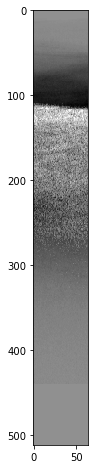

In [57]:
# filenames, raw_images = get_data(cwd+'whole_raw_image/Train','.png')
filenames, raw_images = get_data(cwd+'normalised_raw_image/Train','.png')
# filenames, raw_images = get_data(cwd+'normalised_raw_2/Train','.png')
print(len(filenames))
print(filenames[128])
print (raw_images[0].shape)
plt.imshow(raw_images[2],cmap = "gray")

### Getting Manual Labelled Images

H2_N02047_RVS_1_334_6.png
(512, 64, 3)


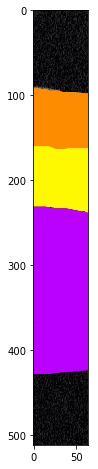

In [58]:
# Getting manual labelled Images
_, manual_labels = get_data(cwd+'manual_label/Train','.png')
print(filenames[128])
print (manual_labels[2].shape)
plt.imshow(manual_labels[0])

### Getting Labels

In [59]:
_, labels_list = get_data(cwd+'/png_labels_method/Train/segmented_ids','.npy')
print(filenames[128])
print(labels_list[2].shape)

H2_N02047_RVS_1_334_6.png
(512, 64)


#### Doing one hot encoding for labels

In [60]:
for ids in labels_list:
    h,w = ids.shape
    if h != 512 or w != 64:
        print(h,w)
print(np.unique(labels_list))

[ 0.  1.  2.  3.  4.  5.  6.  7.]


In [61]:
train_labels = np.zeros((len(filenames),512,64,8))
print(train_labels.shape)
val = 1
for i in range(len(labels_list)) :
    for lab in range(0,8):
        train_labels[i,:,:, lab] = labels_list[i] == lab
print(train_labels.shape)   
print(train_labels[0][0][0])

(600, 512, 64, 8)
(600, 512, 64, 8)
[ 1.  0.  0.  0.  0.  0.  0.  0.]


### Getting Weights

In [62]:
_, weights = get_data(cwd+'/png_labels_method/Train/weights','.npy')
print(filenames[128])
print(len(weights),weights[0].shape)
print(weights[0][0][0])
np.unique(weights)

H2_N02047_RVS_1_334_6.png
600 (512, 64)
1.0


array([  1.,   5.,   6.,  10.,  11.,  14.,  15.,  16.,  20.,  21.,  24.])

### Creating Train and Test Sets

In [63]:
images=raw_images
images=np.array(images)
print(images.shape[0])
images = images.reshape(images.shape[0],512,64,1)

num_files = len(filenames)
validation_cutoff = int(len(filenames)*0.8)

train_indices = np.random.choice(num_files,validation_cutoff,replace = False)

train_images_random = []
train_labels_random = []

for i in train_indices:
    train_images_random.append(images[i])
    train_labels_random.append(train_labels[i])

test_indices = [x for x in range(num_files) if x not in train_indices]
print(test_indices)
test_images = []
test_labels = []

for i in test_indices:
    test_images.append(images[i])
    test_labels.append(train_labels[i])

600
[5, 6, 13, 14, 23, 25, 31, 34, 40, 43, 48, 50, 51, 54, 55, 57, 70, 71, 72, 74, 75, 78, 79, 83, 85, 89, 93, 94, 97, 108, 113, 115, 116, 122, 127, 132, 161, 176, 183, 188, 190, 194, 201, 206, 210, 211, 225, 230, 233, 237, 244, 247, 251, 254, 260, 274, 275, 278, 279, 291, 293, 297, 298, 299, 306, 310, 335, 337, 345, 346, 352, 355, 359, 364, 375, 386, 387, 388, 391, 400, 406, 407, 409, 421, 435, 438, 443, 447, 453, 454, 456, 458, 464, 465, 467, 472, 481, 482, 489, 491, 502, 503, 505, 508, 519, 521, 536, 538, 539, 541, 544, 556, 557, 582, 587, 588, 589, 593, 596, 599]


In [64]:
train_images = np.array(train_images_random)
train_labels = np.array(train_labels_random)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print(train_images.shape, test_images.shape)
print(train_labels.shape, test_labels.shape)

(480, 512, 64, 1) (120, 512, 64, 1)
(480, 512, 64, 8) (120, 512, 64, 8)


In [65]:
train_images = train_images.astype('float32')
train_labels = train_labels.astype('float32')
test_images = test_images.astype('float32')
test_labels = test_labels.astype('float32')
print(train_images.shape)
print(test_images.shape)
print(test_labels.shape)

(480, 512, 64, 1)
(120, 512, 64, 1)
(120, 512, 64, 8)


In [66]:
print (len(train_images))
print (len(train_labels))
print (np.array(train_labels).shape)

480
480
(480, 512, 64, 8)


In [67]:
train_images.shape

(480, 512, 64, 1)

In [68]:
# plt.figure(figsize=(20,10))
# plt.imshow(np.rot90(train_images[0,:,:,0]), cmap=plt.cm.gray)

In [69]:
weights_matrix = []
for i in train_indices:
    weights_matrix.append(weights[i])
print(len(weights_matrix))

480


In [70]:
sample_weights = np.array(weights_matrix)
sample_weights = np.reshape(sample_weights,(validation_cutoff,data_shape))
print(sample_weights.shape)

(480, 32768)


In [71]:
# # (512, 600)
# # 0 black
# # 1 red
# # 2 blue
# # 3 purple
# # 4 lime
# # 5 orange
# # 6 yellow
# # 7 magenta
# # magenta

# print(manual_labels[train_indices[37]][127,:,:]) # The manual label that was done by Columbia
# for i in range(8):
#     print(i)
#     print(train_labels[37,120,:,i]) # the trained_label I return/
# ind = 256

# plt.figure(figsize=(15,2))
# plt.imshow(np.rot90(train_images[ind,:,:,0]), cmap=plt.cm.gray)
# plt.suptitle(filenames[train_indices[ind]], size=15)

# plt.figure(figsize=(15,2))
# plt.imshow(np.rot90(manual_labels[train_indices[ind]]))

# plt.figure(figsize=(15,2))
# plt.imshow(np.rot90(np.reshape(sample_weights[ind], (512,64)) ))

# # All the labels on top of each other
# plt.figure(figsize=(15,2))
# for i in range(7):
#     plt.imshow(np.rot90(train_labels[ind,:,:,i]), alpha=0.2)

# fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(15,20))
# for i, ax in enumerate(axes):
#     ax.imshow(np.rot90(train_labels[ind,:,:,i]))
#     ax.set_title("slice " + str(i))

In [72]:
# for j in range(3):
#     plt.figure(figsize=(15,2))
#     plt.imshow(np.rot90(train_images[j,:,:,0]), cmap=plt.cm.gray)
#     plt.suptitle(filenames[train_indices[j]], size=15)
    
#     print(train_indices[j])
#     plt.figure(figsize=(15,2))
#     plt.imshow(np.rot90(manual_labels[train_indices[j]]))

#     plt.figure(figsize=(15,2))
#     plt.imshow(np.rot90(np.reshape(sample_weights[j], (512,64)) ))

#     # All the labels on top of each other
#     plt.figure(figsize=(15,2))
#     for i in range(8):
#         plt.imshow(np.rot90(train_labels[j,:,:,i]), alpha=0.2)

#     fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(15,20))
#     for i, ax in enumerate(axes):
#         ax.imshow(np.rot90(train_labels[j,:,:,i]))
#         ax.set_title("slice " + str(i))

In [73]:
# fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20,20))
# for i, ax in enumerate(axes):
#     ax.imshow(np.rot90(train_labels[0,:,:,i]))
#     ax.set_title("slice " + str(i))

In [74]:
# first value is number of images
print(len(train_images))
train_labels.shape

480


(480, 512, 64, 8)

In [75]:
train_labels = np.reshape(train_labels,(validation_cutoff,data_shape,8))
test_labels = np.reshape(test_labels,(num_files-validation_cutoff,data_shape,8))

In [76]:
train_labels.shape

(480, 32768, 8)

In [77]:
np.unique(train_labels)

array([ 0.,  1.], dtype=float32)

In [78]:
count = np.zeros(8)
count = np.sum(train_labels==1,axis=(0,1))

In [79]:
# His are floats
new_count = np.zeros(8)
for i in range(8):
    new_count[i] = float(count[i])
#     print(new_count[i])
count = new_count
for i in range(8):
    print(count[i])

6580305.0
4647685.0
526313.0
2834858.0
494165.0
332884.0
190684.0
121746.0


In [80]:
median = np.median(count)

In [81]:
median

510239.0

In [82]:
smooth = 1

In [83]:
train_labels.shape

(480, 32768, 8)

In [84]:
# # Creates a graph.
# a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
# b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
# c = tf.matmul(a, b)
# # # Creates a session with log_device_placement set to True.
# with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
#     # Runs the op.
#     print(sess.run(c))

### Training

In [85]:
lrs = [0.01]
bs = 40
epoch = 200
# named = "models/Trained_Networks/notnormalised_bs50_ep_50"+str(i).replace('.','_')
named = "models/Weights/purple4_red9_green13_magenta10_bs_{}_ep_{}".format(bs,epoch)

In [ ]:
# lrs = [0.01, 0.02, 0.025, 0.03, 0.04]

for i in lrs:
    optimiser = optimizers.Adam(lr = i)
    model.compile(optimizer=optimiser,loss=customized_loss,metrics=['accuracy',dice_coef],sample_weight_mode='temporal')
    
    #Defining Callback functions which will be called by model during runtime when specified condition satisfies
    saved_name = named
    lr_reducer = ReduceLROnPlateau(factor=0.5, cooldown=0, patience=6, min_lr=0.5e-6)
    csv_logger = CSVLogger(saved_name+'.csv')
    model_chekpoint = ModelCheckpoint(saved_name+".hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)
    print('================'+str(i)+'===================')
    model.fit(train_images,train_labels,batch_size=bs,epochs=epoch,validation_data=(test_images,test_labels),sample_weight=sample_weights,callbacks=[lr_reducer, csv_logger,model_chekpoint])
    
    print()

================0.01===================
Train on 480 samples, validate on 120 samples
Epoch 1/200
480/480 [==============================] - 13s 28ms/step - loss: 6.8503 - acc: 0.4831 - dice_coef: 0.3599 - val_loss: 13.6315 - val_acc: 0.0288 - val_dice_coef: 0.0299

### Predictions

In [ ]:
model.load_weights("/home/sim/notebooks/relaynet_pytorch/"+saved_name+".hdf5")
# saved_name = 'notnormalised_bs50_ep_500_01'
# model.load_weights("/home/sim/notebooks/relaynet_pytorch/models/Trained_Networks/"+saved_name+".hdf5")

In [ ]:
SEG_LABELS_LIST = [
#     {"id": -1, "name": "void", "rgb_values": [0, 0, 0]},
    {"id": 0, "name": "void", "rgb_values": [0, 0, 0]}, # black
    {"id": 1, "name": "Myocardium", "rgb_values": [255,0,0]}, # red
    {"id": 2, "name": "Endocardium", "rgb_values": [0, 0, 255]}, # blue
    {"id": 3, "name": "Fibrosis", "rgb_values": [177,10,255]}, # purple
    {"id": 4, "name": "Fat", "rgb_values": [0, 255, 0]}, # green
    {"id": 5, "name": "Dense Collagen", "rgb_values": [255, 140, 0]}, # orange
    {"id": 6, "name": "Loose Collagen", "rgb_values": [255, 255, 0]}, # yellow
    {"id": 7, "name": "Smooth Muscle", "rgb_values": [255,0,255]}# magenta/pink
]; 

def label_img_to_rgb(label_img):
    label_img = np.squeeze(label_img)
    labels = np.unique(label_img)
    label_infos = [l for l in SEG_LABELS_LIST if l['id'] in labels]

    label_img_rgb = np.array([label_img,
                              label_img,
                              label_img]).transpose(1,2,0)
    for l in label_infos:
        mask = label_img == l['id']
        label_img_rgb[mask] = l['rgb_values']

    return label_img_rgb.astype(np.uint8)

In [ ]:
# for i in range(10,11):
#     ind = i
    
#     # Raw Test Image 
#     testing_image = train_images[ind]
#     testing_image = np.squeeze(testing_image,axis = 2)
#     plt.figure(figsize=(20,10))
#     plt.imshow(np.rot90(testing_image), cmap=plt.cm.gray)
    
#     # Manual Test Image 
#     plt.figure(figsize=(15,2))
#     plt.imshow(np.rot90(manual_labels[train_indices[ind]]))

#     plt.figure(figsize=(20,10))
#     new_train_labels = np.copy(train_labels)
#     new_train_labels = new_train_labels.reshape((validation_cutoff,512,64,8))
#     for i in range(7):
#         plt.imshow(np.rot90(new_train_labels[ind,:,:,i]), alpha=0.5)
    
#     fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(50,50))
#     for i, ax in enumerate(axes):
#         ax.imshow(np.rot90(new_train_labels[ind,:,:,i]))
#         ax.set_title("slice " + str(i))
#     plt.show()

#     testing_image = testing_image.reshape((1,512,64,1))
#     prediction = model.predict(testing_image)
#     prediction = np.squeeze(prediction,axis = 0)
    
#     np.argmax(prediction[6999])

#     prediction = np.reshape(prediction,(512,64,8))
#     output = np.zeros((512,64))
#     ground = np.zeros((512,64))
#     for i in range(512):
#         for j in range(64):
#             index = np.argmax(prediction[i][j])
#             output[i][j] = index
#     test_labels[0].shape

#     # test_labels[20][6999]

#     test_ground_truth = np.reshape(train_labels[ind],(512,64,8))
#     for i in range(512):
#         for j in range(64):
#             index = np.argmax(test_ground_truth[i][j])
#             ground[i][j] = index
#     for i in range(512):
#         for j in range(64):
#             index = np.argmax(prediction[i][j])
#             output[i][j] = index
#     print (output.shape)
    
#     print(np.unique(output))

#     color = np.zeros((512,64,3))
#     c0 = 0
#     c1 = 0
#     c2 = 0
#     c3 = 0
#     c4 = 0
#     c5 = 0
#     c6 = 0
#     c7 = 0
#     for j in range(512):
#         for k in range(64):
#             if(output[j][k]==0):
#                 c0 = c0 + 1
#                 color[j][k] = [0,0,0]
#             if(output[j][k]==1):
#                 c1 = c1 + 1
#                 color[j][k] = [255,0,0]
#             if(output[j][k]==2):
#                 c2 = c2 + 1
#                 color[j][k] = [0, 0, 255]
#             if(output[j][k]==3):
#                 c3 = c3 + 1
#                 color[j][k] = [177,10,255] 
#             if(output[j][k]==4):
#                 c4 = c4 + 1
#                 color[j][k] = [0,255,0]
#             if(output[j][k]==5):
#                 c5 = c5 + 1
#                 color[j][k] = [255, 140, 0]
#             if(output[j][k]==6):
#                 c6 = c6 + 1
#                 color[j][k] = [255, 255, 0]
#             if(output[j][k]==7):
#                 c7 = c7 + 1
#                 color[j][k] = [255,0,255]

#     print('index 0:', c0)
#     print('index 1:', c1)
#     print('index 2:', c2)
#     print('index 3:', c3)
#     print('index 4:', c4)
#     print('index 5:', c5)
#     print('index 6:', c6)
#     print('index 7:', c7)

#     %matplotlib inline
#     plt.figure(figsize=(20,10))
#     plt.imshow(np.rot90(color))

In [ ]:
for i in range(10,11):
    ind = i

    # Raw Test Image 
    testing_image = train_images[ind]
    testing_image = np.squeeze(testing_image,axis = 2)
    plt.figure(figsize=(20,10))
    plt.imshow(np.rot90(testing_image), cmap=plt.cm.gray)

    # Manual Test Image 
    plt.figure(figsize=(15,2))
    plt.imshow(np.rot90(manual_labels[train_indices[ind]]))

    # Layers all overlayed
    # plt.figure(figsize=(20,10))
    # new_train_labels = np.copy(train_labels)
    # new_train_labels = new_train_labels.reshape((validation_cutoff,512,64,8))
    # for i in range(7):
    #     plt.imshow(np.rot90(new_train_labels[ind,:,:,i]), alpha=0.5)

    # fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20,20))
    # for i, ax in enumerate(axes):
    #     ax.imshow(np.rot90(new_train_labels[ind,:,:,i]))
    #     ax.set_title("slice " + str(i))

    plt.show()

    testing_image = testing_image.reshape((1,512,64,1))
    print(testing_image.shape)
    prediction = model.predict(testing_image)
    prediction = np.squeeze(prediction,axis = 0)

    # np.argmax(prediction[6999])

    prediction = np.reshape(prediction,(512,64,8))
    output = np.zeros((512,64))
    ground = np.zeros((512,64))
    for i in range(512):
        for j in range(64):
            index = np.argmax(prediction[i][j])
            output[i][j] = index
    test_labels[0].shape

    # test_labels[20][6999]

    test_ground_truth = np.reshape(train_labels[ind],(512,64,8))
    for i in range(512):
        for j in range(64):
            index = np.argmax(test_ground_truth[i][j])
            ground[i][j] = index
    for i in range(512):
        for j in range(64):
            index = np.argmax(prediction[i][j])
            output[i][j] = index
    print (output.shape)

    print(np.unique(train_labels[ind]))
    print(np.unique(output))

    color = label_img_to_rgb(output)

    %matplotlib inline
    plt.figure(figsize=(20,10))
    plt.imshow(np.rot90(color))

    plt.figure(figsize=(20,10))
    for i in range(7):
        plt.imshow(np.rot90(output), alpha=0.5)

    new_output = np.zeros((512,64,8))
    for j in range(512) :
        for k in range(64):
            if(output[j][k] == 0):
                new_output[j][k][0] = 1
            if(output[j][k] == 1):
                new_output[j][k][1] = 1
            if(output[j][k] == 2):
                new_output[j][k][2] = 1
            if(output[j][k] == 3):
                new_output[j][k][3] = 1
            if(output[j][k] == 4):
                new_output[j][k][4] = 1
            if(output[j][k] == 5):
                new_output[j][k][5] = 1
            if(output[j][k] == 6):
                new_output[j][k][6] = 1
            if(output[j][k] == 7):
                new_output[j][k][7] = 1
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20,20))
    for i, ax in enumerate(axes):
        ax.imshow(np.rot90(new_output[:,:,i]))
        ax.set_title("slice " + str(i))
    plt.show()

In [ ]:
# For notnormalised, 10 and 11 are good example pics of a fuck up

In [ ]:
ind = 11

# Raw Test Image 
testing_image = train_images[ind]
testing_image = np.squeeze(testing_image,axis = 2)
plt.figure(figsize=(20,10))
plt.imshow(np.rot90(testing_image), cmap=plt.cm.gray)

# Manual Test Image 
plt.figure(figsize=(15,2))
plt.imshow(np.rot90(manual_labels[train_indices[ind]]))

# Layers all overlayed
# plt.figure(figsize=(20,10))
# new_train_labels = np.copy(train_labels)
# new_train_labels = new_train_labels.reshape((validation_cutoff,512,64,8))
# for i in range(7):
#     plt.imshow(np.rot90(new_train_labels[ind,:,:,i]), alpha=0.5)

# fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20,20))
# for i, ax in enumerate(axes):
#     ax.imshow(np.rot90(new_train_labels[ind,:,:,i]))
#     ax.set_title("slice " + str(i))

plt.show()

testing_image = testing_image.reshape((1,512,64,1))
print(testing_image.shape)
prediction = model.predict(testing_image)
prediction = np.squeeze(prediction,axis = 0)

# np.argmax(prediction[6999])

prediction = np.reshape(prediction,(512,64,8))
output = np.zeros((512,64))
ground = np.zeros((512,64))
for i in range(512):
    for j in range(64):
        index = np.argmax(prediction[i][j])
        output[i][j] = index
test_labels[0].shape

# test_labels[20][6999]

test_ground_truth = np.reshape(train_labels[ind],(512,64,8))
for i in range(512):
    for j in range(64):
        index = np.argmax(test_ground_truth[i][j])
        ground[i][j] = index
for i in range(512):
    for j in range(64):
        index = np.argmax(prediction[i][j])
        output[i][j] = index
print (output.shape)

print(np.unique(train_labels[ind]))
print(np.unique(output))

color = label_img_to_rgb(output)

%matplotlib inline
plt.figure(figsize=(20,10))
plt.imshow(np.rot90(color))

plt.figure(figsize=(20,10))
for i in range(7):
    plt.imshow(np.rot90(output), alpha=0.5)
    
new_output = np.zeros((512,64,8))
for j in range(512) :
    for k in range(64):
        if(output[j][k] == 0):
            new_output[j][k][0] = 1
        if(output[j][k] == 1):
            new_output[j][k][1] = 1
        if(output[j][k] == 2):
            new_output[j][k][2] = 1
        if(output[j][k] == 3):
            new_output[j][k][3] = 1
        if(output[j][k] == 4):
            new_output[j][k][4] = 1
        if(output[j][k] == 5):
            new_output[j][k][5] = 1
        if(output[j][k] == 6):
            new_output[j][k][6] = 1
        if(output[j][k] == 7):
            new_output[j][k][7] = 1
fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(20,20))
for i, ax in enumerate(axes):
    ax.imshow(np.rot90(new_output[:,:,i]))
    ax.set_title("slice " + str(i))
plt.show()

In [ ]:
# init_g = tf.global_variables_initializer()
# init_l = tf.local_variables_initializer()
# with tf.Session() as sess:
#     sess.run(init_g)
#     sess.run(init_l)
# #     var = [v for v in tf.trainable_variables()]

# #     vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
#     tvars = tf.trainable_variables()
#     tvars_vals = sess.run(tvars)

#     for var, val in zip(tvars, tvars_vals):
#         print(var.name, val)